In [236]:
import os
import numpy as np,numpy
import pandas as pd
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [237]:
def LDA(train_data,y_train,test_data,y_test,vectors):
    
    df = pd.DataFrame(train_data)
    df['class'] = y_train
    
    classes = numpy.sort(df['class'].unique())  #classes matrix
    mean_mat = df.groupby('class').mean().values  # mean for each class matrix
    samples_c = df.groupby('class').size().values  #nu of samples per class
    
    #between classes matrix
    u = mean_mat.mean(0).reshape(1, train_data.shape[1])         #u  (mean of all classes)
    B = numpy.zeros(shape=(train_data.shape[1], train_data.shape[1]))

    for i in range(classes.size):
        nk = samples_c[i]                                        #nk (nu of samples for class)
        uk = mean_mat[i].reshape(1, train_data.shape[1])         #uk (mean of class)
        t = uk - u
        B += nk * numpy.matmul(t.T, t)
    #print(B)
    
    #within class matrix
    S = numpy.zeros(shape=(train_data.shape[1], train_data.shape[1]))

    for i in range(classes.size):
        class_ss = df.loc[df['class'] == i + 1].values[:, :-1]       #class_ss --> class samples
        class_m = mean_mat[i].reshape(1, train_data.shape[1])         #class_m --> class mean
        centered_data = numpy.subtract(class_ss, class_m) 
        s = numpy.matmul(centered_data.T, centered_data)
        S = S + s    #print(S)
    
    #eigen calculations
    S_inv = numpy.linalg.inv(S)    #print(S_inv)
    eigen_values, eigen_vectors = numpy.linalg.eigh(numpy.matmul(S_inv, B))
    
    #sort the eigenvalues and eigenvectors in descending order
    sorted_index = numpy.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:, sorted_index]
    
    U = sorted_eigenvectors[:, 0:vectors]
    X_train = numpy.matmul(train_data, U)
    X_test = numpy.matmul(test_data, U)

    return X_train , X_test

In [238]:
def plot(k_vals):
    acc=[]
    for i in range(len(k_vals)):
        knn = KNeighborsClassifier(n_neighbors=k_vals[i])
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))

    plt.plot(k_vals,acc, linestyle = 'dashed')
    plt.show()
    print("Accuracy:", acc)

In [239]:
data_matrix = numpy.ndarray(shape=(400, 10304), dtype=numpy.dtype('u1'))  # 8-bit unsigned int
label_vector = numpy.empty(shape=(400, 1), dtype=numpy.dtype('u1'))

i = 0
for dirname, _, filenames in os.walk('C:\\Users\\smart\\Desktop\\FaceRecognition-master\\dataset'):
    for filename in filenames:
        image = Image.open(os.path.join(dirname, filename))
        numpy_image = numpy.asarray(image).flatten()
        data_matrix[i] = numpy_image.copy()
        label_vector[i] = int(dirname[dirname.rindex('\\') + 2:])
        i += 1


In [225]:
# Odd rows for training
train_data = data_matrix[::2, :]
y_train = label_vector[::2, :].ravel()
# Even rows for testing
test_data = data_matrix[1::2, :]
y_test = label_vector[1::2, :].ravel()

print(train_data.shape)
print(y_train.shape)

print(test_data.shape)
print(y_test.shape)
print(type(train_data))
print(type(y_train))

print(type(test_data))
print(type(y_test))

(200, 10304)
(200,)
(200, 10304)
(200,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


1

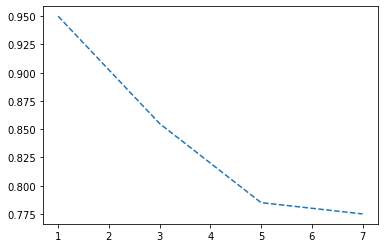

Accuracy: [0.95, 0.855, 0.785, 0.775]


In [185]:
X_train , X_test=LDA(train_data,y_train,test_data,y_test,39)
plot([1,3,5,7])

In [186]:
#non faces
non_faces = numpy.ndarray(shape=(374, 10304), dtype=numpy.dtype('u1'))  # 8-bit unsigned int
i = 0
for dirname, _, filenames in os.walk('C:\\Users\\smart\\Desktop\\non_faces'):
    for filename in filenames:
        image = Image.open(os.path.join(dirname, filename))
        image = image.resize((92,112))
        numpy_image = numpy.asarray(image).flatten()
        non_faces[i] = numpy_image.copy()
        i += 0 

In [187]:
df['class']=1
df1=pd.DataFrame(non_faces[:200])
df1['class']=0
df = df.append(df1, ignore_index=True)

In [199]:
# Odd rows for training
train_data = df.values[::2, :-1]
y_train = df['class'].values[::2].ravel()

# Even rows for testing
test_data = df.values[1::2, :-1]
y_test = df['class'].values[1::2].ravel()

print(train_data.shape)
print(y_train.shape)

print(test_data.shape)
print(y_test.shape)


(300, 10304)
(300,)
(300, 10304)
(300,)


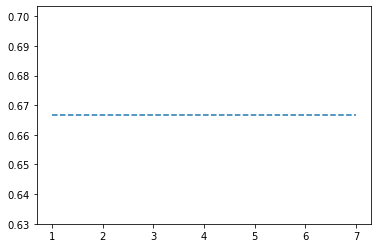

Accuracy: [0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666]


In [189]:
#acc=1 as most of non faces are black (  more than 75% of pgm =0)
X_train , X_test=LDA(train_data,y_train,test_data,y_test,1)
plot([1,3,5,7])

In [264]:
train_data=np.empty((280,10304))
y_train= np.empty((280,1))
test_data= np.empty((120,10304))
y_test= np.empty((120,1))

x=0
y=0
for i in range(40):
    for j in range(7):
        train_data[x][:]=data_matrix[(i*10)+j][:]
        y_train[x]=label_vector[(i*10)+j][0]
        x=x+1
    for j in range(3):
        test_data[y]=data_matrix[(i*10)+7+j][:]
        y_train[y]=label_vector[(i*10)+7+j][0]
        y+=1
        

C:\Users\smart\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\smart\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\smart\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\smart\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

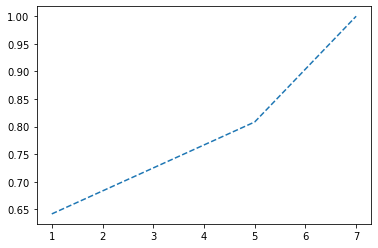

Accuracy: [0.6416666666666667, 0.725, 0.8083333333333333, 1.0]


In [265]:
X_train , X_test=LDA(train_data,y_train,test_data,y_test,39)
plot([1,3,5,7])